In [5]:
from pathlib import Path
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.nn.utils import clip_grad_norm_
import numpy as np

inputs_variable1 = ['U', 'V', 'T', 'Q', 'CLDLIQ', 'CLDICE', 'PMID', 'DPRES', 'Z3', 'HEIGHT']
inputs_variable2 = ['TAUX', 'TAUY', 'SHFLX', 'LHFLX']
output_variable1 = ['SPDQ', 'SPDQC', 'SPDQI', 'SPNC', 'SPNI', 'SPDT', 'CLOUD', 'CLOUDTOP']
output_variable2 = ['PRECC', 'PRECSC']

data_path = Path("/home/ET/mnwong/ML/data/Qobs10_SPCAMM.000.cam.h1.0001-02-13-00800.nc")
with xr.open_dataset(data_path) as ds:
    display(ds)
    print("\nData variables:", list(ds.data_vars))
    print("Coordinates:", list(ds.coords))

<xarray.Dataset>
Dimensions:       (lat: 384, lon: 576, lev: 30, ilev: 31, time: 27, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -89.53 -89.06 -88.59 ... 89.06 89.53 90.0
  * lon           (lon) float64 0.0 0.625 1.25 1.875 ... 357.5 358.1 358.8 359.4
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 0001-02-13 00:13:20 ... 0001-02-13 06:00:00
Dimensions without coordinates: nbnd
Data variables: (12/64)
    gw            (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    hyai          (ilev) float64 ...
    hybi          (ilev) float64 ...
    ...            ...
    T             (time, lev, lat, lon) float64 ...
    TAUX          (time, lat, lon) float64 ...
    TAUY          (time, lat, lon) float64 ...
    U             (time, lev, lat, lon) float64 ...
    V             (time, lev, lat, lon) float64 ...
    Z3            (time, lev, lat, lon) float64 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              Qobs10_SPCAMM.000_cont
    logname:           tnchow
    host:              
    initial_file:      /home/ET/tnchow/cesm/Qobs10_SPCAMM.000/run/Qobs10_init...
    topography_file:   bnd_topo
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  second_800


Data variables: ['gw', 'hyam', 'hybm', 'P0', 'hyai', 'hybi', 'date', 'datesec', 'time_bnds', 'date_written', 'time_written', 'ndbase', 'nsbase', 'nbdate', 'nbsec', 'mdt', 'ndcur', 'nscur', 'co2vmr', 'ch4vmr', 'n2ovmr', 'f11vmr', 'f12vmr', 'sol_tsi', 'nsteph', 'CLDHGH', 'CLDICE', 'CLDLIQ', 'CLDLOW', 'CLDMED', 'CLDTOT', 'CLOUD', 'CLOUDTOP', 'DPRES', 'FLNS', 'FLNT', 'FSDS', 'FSNS', 'FSNT', 'HEIGHT', 'LHFLX', 'NUMICE', 'NUMLIQ', 'PHIS', 'PMID', 'PRECC', 'PRECSC', 'PS', 'Q', 'QRL', 'QRS', 'SHFLX', 'SPDQ', 'SPDQC', 'SPDQI', 'SPDT', 'SPNC', 'SPNI', 'T', 'TAUX', 'TAUY', 'U', 'V', 'Z3']
Coordinates: ['lat', 'lon', 'lev', 'ilev', 'time']


In [6]:
# 查看纬度和经度坐标信息
print("纬度范围:", ds.lat.min().values, "到", ds.lat.max().values)
print("经度范围:", ds.lon.min().values, "到", ds.lon.max().values)
print("纬度形状:", ds.lat.shape)
print("经度形状:", ds.lon.shape)
print("\n纬度坐标:")
print(ds.lat.values[:10], "...", ds.lat.values[-10:])
print("\n经度坐标:")
print(ds.lon.values[:10], "...", ds.lon.values[-10:])

纬度范围: -90.0 到 90.0
经度范围: 0.0 到 359.375
纬度形状: (384,)
经度形状: (576,)

纬度坐标:
[-90.         -89.53002611 -89.06005222 -88.59007833 -88.12010444
 -87.65013055 -87.18015666 -86.71018277 -86.24020888 -85.77023499] ... [85.77023499 86.24020888 86.71018277 87.18015666 87.65013055 88.12010444
 88.59007833 89.06005222 89.53002611 90.        ]

经度坐标:
[0.    0.625 1.25  1.875 2.5   3.125 3.75  4.375 5.    5.625] ... [353.75  354.375 355.    355.625 356.25  356.875 357.5   358.125 358.75
 359.375]


In [7]:
import math

def create_polar_sampling_mask(ds, lat_threshold=60):
    """
    创建极地采样掩码
    对于纬度绝对值大于lat_threshold的区域，按cos(|lat|)比例进行经度采样
    
    Args:
        ds: xarray数据集
        lat_threshold: 纬度阈值，默认60度
    
    Returns:
        sampling_mask: 布尔数组，形状为(lat, lon)
    """
    lats = ds.lat.values
    lons = ds.lon.values
    
    # 创建采样掩码
    sampling_mask = np.ones((len(lats), len(lons)), dtype=bool)
    
    for i, lat in enumerate(lats):
        abs_lat = abs(lat)
        if abs_lat > lat_threshold:
            # 计算采样比例
            sampling_ratio = math.cos(math.radians(abs_lat))
            
            # 计算需要采样的经度点数
            n_lons_to_sample = max(1, int(len(lons) * sampling_ratio))
            
            # 均匀采样经度索引
            lon_indices = np.linspace(0, len(lons)-1, n_lons_to_sample, dtype=int)
            
            # 创建该纬度的掩码（只保留采样的经度点）
            lat_mask = np.zeros(len(lons), dtype=bool)
            lat_mask[lon_indices] = True
            sampling_mask[i, :] = lat_mask
            
            print(f"纬度 {lat:.1f}°: 采样比例 {sampling_ratio:.3f}, 采样 {n_lons_to_sample}/{len(lons)} 个经度点")
    
    return sampling_mask

# 创建采样掩码
sampling_mask = create_polar_sampling_mask(ds, lat_threshold=60)
print(f"\n采样掩码形状: {sampling_mask.shape}")
print(f"总的有效采样点: {sampling_mask.sum()}/{sampling_mask.size}")
print(f"采样比例: {sampling_mask.sum()/sampling_mask.size:.3f}")

纬度 -90.0°: 采样比例 0.000, 采样 1/576 个经度点
纬度 -89.5°: 采样比例 0.008, 采样 4/576 个经度点
纬度 -89.1°: 采样比例 0.016, 采样 9/576 个经度点
纬度 -88.6°: 采样比例 0.025, 采样 14/576 个经度点
纬度 -88.1°: 采样比例 0.033, 采样 18/576 个经度点
纬度 -87.7°: 采样比例 0.041, 采样 23/576 个经度点
纬度 -87.2°: 采样比例 0.049, 采样 28/576 个经度点
纬度 -86.7°: 采样比例 0.057, 采样 33/576 个经度点
纬度 -86.2°: 采样比例 0.066, 采样 37/576 个经度点
纬度 -85.8°: 采样比例 0.074, 采样 42/576 个经度点
纬度 -85.3°: 采样比例 0.082, 采样 47/576 个经度点
纬度 -84.8°: 采样比例 0.090, 采样 51/576 个经度点
纬度 -84.4°: 采样比例 0.098, 采样 56/576 个经度点
纬度 -83.9°: 采样比例 0.106, 采样 61/576 个经度点
纬度 -83.4°: 采样比例 0.115, 采样 66/576 个经度点
纬度 -83.0°: 采样比例 0.123, 采样 70/576 个经度点
纬度 -82.5°: 采样比例 0.131, 采样 75/576 个经度点
纬度 -82.0°: 采样比例 0.139, 采样 80/576 个经度点
纬度 -81.5°: 采样比例 0.147, 采样 84/576 个经度点
纬度 -81.1°: 采样比例 0.155, 采样 89/576 个经度点
纬度 -80.6°: 采样比例 0.163, 采样 94/576 个经度点
纬度 -80.1°: 采样比例 0.171, 采样 98/576 个经度点
纬度 -79.7°: 采样比例 0.179, 采样 103/576 个经度点
纬度 -79.2°: 采样比例 0.188, 采样 108/576 个经度点
纬度 -78.7°: 采样比例 0.196, 采样 112/576 个经度点
纬度 -78.3°: 采样比例 0.204, 采样 117/576 个经度点
纬度 -77.8°: 

In [8]:
def process_variable_with_polar_sampling(ds, var_name, sampling_mask, variable_type='3D'):
    """
    处理变量并应用极地采样
    
    Args:
        ds: xarray数据集
        var_name: 变量名
        sampling_mask: 采样掩码 (lat, lon)
        variable_type: '3D' 表示有高度维度，'2D' 表示只有lat/lon
    
    Returns:
        reshaped_tensor: 处理后的张量
    """
    var_data = np.array(ds[var_name])
    
    if variable_type == '3D':
        # 形状: (time, height, lat, lon)
        # 应用采样掩码到lat和lon维度
        sampled_data = []
        for t in range(var_data.shape[0]):
            for h in range(var_data.shape[1]):
                # 获取当前时间和高度的数据切片
                data_slice = var_data[t, h, :, :]
                # 应用采样掩码
                sampled_points = data_slice[sampling_mask]
                sampled_data.append(sampled_points)
        
        # 重塑为 (time*height*sampled_points,) 然后再重塑
        sampled_data = np.array(sampled_data)
        # 转换为 (time*sampled_points, height)
        reshaped = sampled_data.reshape(var_data.shape[0], -1, var_data.shape[1]).transpose(0, 2, 1).reshape(-1, var_data.shape[1])
        
    else:  # 2D variables
        # 形状: (time, lat, lon)
        sampled_data = []
        for t in range(var_data.shape[0]):
            data_slice = var_data[t, :, :]
            sampled_points = data_slice[sampling_mask]
            sampled_data.append(sampled_points)
        
        # 重塑为 (time*sampled_points, 1)
        reshaped = np.array(sampled_data).reshape(-1, 1)
    
    # 转换为tensor并标准化
    reshaped_tensor = torch.tensor(reshaped).float()
    mean = reshaped_tensor.mean(dim=0, keepdim=True)
    std = reshaped_tensor.std(dim=0, keepdim=True)
    reshaped_tensor = (reshaped_tensor - mean) / (std + 1e-6)
    
    return reshaped_tensor

# 处理输入变量
print("处理输入变量...")
tensors_to_concat = []

# 处理3D输入变量 (有高度维度)
for var in inputs_variable1:
    print(f"处理变量: {var}")
    tensor = process_variable_with_polar_sampling(ds, var, sampling_mask, '3D')
    tensors_to_concat.append(tensor)
    print(f"  - 形状: {tensor.shape}")

# 处理2D输入变量 (没有高度维度)  
for var in inputs_variable2:
    print(f"处理变量: {var}")
    tensor = process_variable_with_polar_sampling(ds, var, sampling_mask, '2D')
    tensors_to_concat.append(tensor)
    print(f"  - 形状: {tensor.shape}")

X_sampled = torch.cat(tensors_to_concat, dim=1)
print(f"\n输入数据最终形状: {X_sampled.shape}")

# 处理输出变量
print("\n处理输出变量...")
tensors_to_concat_y = []

# 处理3D输出变量
for var in output_variable1:
    print(f"处理变量: {var}")
    tensor = process_variable_with_polar_sampling(ds, var, sampling_mask, '3D')
    tensors_to_concat_y.append(tensor)
    print(f"  - 形状: {tensor.shape}")

# 处理2D输出变量
for var in output_variable2:
    print(f"处理变量: {var}")
    tensor = process_variable_with_polar_sampling(ds, var, sampling_mask, '2D')
    tensors_to_concat_y.append(tensor)
    print(f"  - 形状: {tensor.shape}")

Y_sampled = torch.cat(tensors_to_concat_y, dim=1)
print(f"\n输出数据最终形状: {Y_sampled.shape}")

print(f"\n采样前后数据点数比较:")
print(f"原始数据点数: {27 * 384 * 576} (时间 × 纬度 × 经度)")
print(f"采样后数据点数: {X_sampled.shape[0]}")
print(f"数据压缩比: {X_sampled.shape[0] / (27 * 384 * 576):.3f}")

处理输入变量...
处理变量: U
  - 形状: torch.Size([4482594, 30])
处理变量: V
  - 形状: torch.Size([4482594, 30])
处理变量: T
  - 形状: torch.Size([4482594, 30])
处理变量: Q
  - 形状: torch.Size([4482594, 30])
处理变量: CLDLIQ
  - 形状: torch.Size([4482594, 30])
处理变量: CLDICE
  - 形状: torch.Size([4482594, 30])
处理变量: PMID
  - 形状: torch.Size([4482594, 30])
处理变量: DPRES
  - 形状: torch.Size([4482594, 30])
处理变量: Z3
  - 形状: torch.Size([4482594, 30])
处理变量: HEIGHT
  - 形状: torch.Size([4482594, 31])
处理变量: TAUX
  - 形状: torch.Size([4482594, 1])
处理变量: TAUY
  - 形状: torch.Size([4482594, 1])
处理变量: SHFLX
  - 形状: torch.Size([4482594, 1])
处理变量: LHFLX
  - 形状: torch.Size([4482594, 1])

输入数据最终形状: torch.Size([4482594, 305])

处理输出变量...
处理变量: SPDQ
  - 形状: torch.Size([4482594, 30])
处理变量: SPDQC
  - 形状: torch.Size([4482594, 30])
处理变量: SPDQI
  - 形状: torch.Size([4482594, 30])
处理变量: SPNC
  - 形状: torch.Size([4482594, 30])
处理变量: SPNI
  - 形状: torch.Size([4482594, 30])
处理变量: SPDT
  - 形状: torch.Size([4482594, 30])
处理变量: CLOUD
  - 形状: torch.Size([4482594, 30])
处理

## 使用新的极地采样数据进行训练

现在我们可以使用经过极地采样优化的数据 (`X_sampled`, `Y_sampled`) 来替代原始数据进行模型训练。这样可以减少极地地区的过采样问题，同时节省约25%的存储空间和计算资源。

In [9]:
# 使用采样后的数据创建新的数据集
from torch.utils.data import TensorDataset, random_split

# Convert to float32 for GPU efficiency
X_sampled = X_sampled.float()
Y_sampled = Y_sampled.float()

# Create dataset with sampled data
dataset_sampled = TensorDataset(X_sampled, Y_sampled)

# Split dataset into 80% training and 20% testing
total_size = len(dataset_sampled)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset_sampled, test_dataset_sampled = random_split(dataset_sampled, [train_size, test_size])

print(f"采样后数据集统计:")
print(f"总样本数: {total_size:,}")
print(f"训练样本数: {train_size:,}")
print(f"测试样本数: {test_size:,}")

# Create dataloaders
# train_loader_sampled = DataLoader(train_dataset_sampled, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
train_loader_sampled = DataLoader(train_dataset_sampled, batch_size=256, shuffle=True)
test_loader_sampled = DataLoader(test_dataset_sampled, batch_size=256, shuffle=False)

print(f"训练批次数: {len(train_loader_sampled)}")
print(f"测试批次数: {len(test_loader_sampled)}")

# 比较采样前后的内存占用
original_memory = 27 * 384 * 576 * (305 + 242) * 4 / (1024**3)  # GB
sampled_memory = X_sampled.shape[0] * (305 + 242) * 4 / (1024**3)  # GB

print(f"\n内存占用比较:")
print(f"原始数据: {original_memory:.2f} GB")
print(f"采样数据: {sampled_memory:.2f} GB") 
print(f"节省内存: {original_memory - sampled_memory:.2f} GB ({(1-sampled_memory/original_memory):.1%})")

采样后数据集统计:
总样本数: 4,482,594
训练样本数: 3,586,075
测试样本数: 896,519
训练批次数: 14009
测试批次数: 3503

内存占用比较:
原始数据: 12.17 GB
采样数据: 9.13 GB
节省内存: 3.03 GB (24.9%)


## 极地采样解决方案总结

### 问题描述
原始数据在极地地区（纬度±60°以外）存在过采样问题，因为经纬度网格在极地的密度过高。

### 解决方案
实现了基于 `cos(|lat|)` 的自适应采样策略：

1. **采样规则**：
   - 对于 `|纬度| ≤ 60°` 的区域：保持100%采样
   - 对于 `|纬度| > 60°` 的区域：采样比例 = `cos(|纬度|)`
   - 在每个纬度上均匀选择经度点进行采样

2. **采样效果**：
   - 数据点从 5,971,968 减少到 4,482,594
   - 数据压缩比：75.1%（节省24.9%存储空间）
   - 极地区域采样比例：25.2%
   - 中低纬度区域：保持100%采样

3. **优势**：
   - 减少极地过采样，提高数据质量
   - 节省约25%的存储空间和计算资源  
   - 保持中低纬度区域的完整信息
   - 采样模式符合地球表面面积分布

### 使用方法
现在可以使用 `X_sampled` 和 `Y_sampled` 替代原始的 `X` 和 `Y` 进行模型训练，或者使用新创建的 `train_loader_sampled` 和 `test_loader_sampled`。

In [10]:
X_sampled.shape
Y_sampled.shape

torch.Size([4482594, 242])

In [11]:
from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Create dataset
dataset = TensorDataset(X_sampled, Y_sampled)

# Split dataset into 80% training and 20% testing
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Testing samples: {test_size}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Initialize model and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Calculate R² score for better evaluation
def calculate_r2_score(model, test_loader, device):
    model.eval()
    y_true_list = []
    y_pred_list = []
    
    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            outputs = model(batch_X)
            y_true_list.append(batch_Y.cpu())
            y_pred_list.append(outputs.cpu())
    
    y_true = torch.cat(y_true_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    
    # Calculate R² score
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return r2.item()


Total samples: 4482594
Training samples: 3586075
Testing samples: 896519
Using device: cuda


In [12]:
# 改进版本1: 更简单的架构 + 更好的正则化
class ImprovedNet_v1(nn.Module):
    def __init__(self, input_dim=305, output_dim=242):
        super(ImprovedNet_v1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        
        # Xavier初始化
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        x = self.dropout1(self.leaky_relu(self.fc1(x)))
        x = self.dropout2(self.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# 改进版本2: 残差连接 + 更深层次
class ImprovedNet_v2(nn.Module):
    def __init__(self, input_dim=305, output_dim=242, hidden_dim=256):
        super(ImprovedNet_v2, self).__init__()
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        
        # 残差块
        self.residual_block1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )
        
        self.residual_block2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim)
        )
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.input_projection(x)
        
        # 残差连接
        residual1 = self.residual_block1(x)
        x = self.relu(x + residual1)
        
        residual2 = self.residual_block2(x)
        x = self.relu(x + residual2)
        
        x = self.output_layer(x)
        return x

# 改进版本3: 注意力机制
class ImprovedNet_v3(nn.Module):
    def __init__(self, input_dim=305, output_dim=242):
        super(ImprovedNet_v3, self).__init__()
        
        # 特征提取层
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        
        # 自注意力层
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, dropout=0.1, batch_first=True)
        self.layer_norm = nn.LayerNorm(512)
        
        # 输出层
        self.output_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, x):
        # 特征提取
        features = self.feature_extractor(x)
        
        # 为注意力机制添加序列维度
        features = features.unsqueeze(1)  # (batch_size, 1, 512)
        
        # 自注意力
        attn_output, _ = self.attention(features, features, features)
        attn_output = self.layer_norm(features + attn_output)  # 残差连接
        
        # 移除序列维度
        attn_output = attn_output.squeeze(1)  # (batch_size, 512)
        
        # 输出
        output = self.output_layers(attn_output)
        return output


In [13]:
# Improved training function - with better learning rate scheduling and early stopping
def train_improved_model(model, train_loader, test_loader, num_epochs=10, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Use a smaller learning rate
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Learning rate scheduler - for a more gentle decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, verbose=True, min_lr=1e-6
    )
    
    # Loss function - can try Huber Loss instead of MSE
    criterion = nn.HuberLoss(delta=1.0)  # More robust to outliers
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_X, batch_Y in train_pbar:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_train_loss += loss.item()
            train_pbar.set_postfix({'Loss': f'{loss.item():.6f}', 'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'})
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch_X, batch_Y in test_loader:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_test_loss)
        
        # Early stopping check
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}, Best: {best_test_loss:.6f}')
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    return model, train_losses, test_losses

print("Improved training function has been defined!")

Improved training function has been defined!


In [14]:
# 训练和比较三个改进版本
models_to_test = [
    ("Simple Improved", ImprovedNet_v1()),
    ("Residual Network", ImprovedNet_v2()),
    ("Attention Network", ImprovedNet_v3())
]

results = {}

for name, model in models_to_test:
    print(f"\n{'='*50}")
    print(f"训练模型: {name}")
    print(f"{'='*50}")
    
    # 计算参数数量
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"参数数量: {total_params:,}")
    
    # 训练模型
    trained_model, train_losses, test_losses = train_improved_model(
        model, train_loader, test_loader, num_epochs=5, patience=8
    )
    
    # 计算最终性能
    final_train_loss = train_losses[-1]
    final_test_loss = test_losses[-1]
    best_test_loss = min(test_losses)
    
    # 计算R²分数
    r2 = calculate_r2_score(trained_model, test_loader, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    results[name] = {
        'model': trained_model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'final_train_loss': final_train_loss,
        'final_test_loss': final_test_loss,
        'best_test_loss': best_test_loss,
        'r2_score': r2,
        'num_params': total_params
    }
    
    print(f"最终训练损失: {final_train_loss:.6f}")
    print(f"最终测试损失: {final_test_loss:.6f}")
    print(f"最佳测试损失: {best_test_loss:.6f}")
    print(f"R²分数: {r2:.6f}")

print(f"\n{'='*50}")
print("所有模型训练完成！")
print(f"{'='*50}")


训练模型: Simple Improved
参数数量: 142,450


Epoch 1/5 [Train]: 100%|██████████| 14009/14009 [01:38<00:00, 142.22it/s, Loss=0.066978, LR=1.00e-03]


Epoch [1/5], Train Loss: 0.072834, Test Loss: 0.061064, Best: 0.061064


Epoch 2/5 [Train]: 100%|██████████| 14009/14009 [01:36<00:00, 144.85it/s, Loss=0.061992, LR=1.00e-03]


Epoch [2/5], Train Loss: 0.069110, Test Loss: 0.059986, Best: 0.059986


Epoch 3/5 [Train]: 100%|██████████| 14009/14009 [01:33<00:00, 149.09it/s, Loss=0.084844, LR=1.00e-03]


Epoch [3/5], Train Loss: 0.068858, Test Loss: 0.059990, Best: 0.059986


Epoch 4/5 [Train]: 100%|██████████| 14009/14009 [01:33<00:00, 149.14it/s, Loss=0.097489, LR=1.00e-03]


Epoch [4/5], Train Loss: 0.068715, Test Loss: 0.059674, Best: 0.059674


Epoch 5/5 [Train]: 100%|██████████| 14009/14009 [01:33<00:00, 149.49it/s, Loss=0.051589, LR=1.00e-03]


Epoch [5/5], Train Loss: 0.068653, Test Loss: 0.059670, Best: 0.059670
最终训练损失: 0.068653
最终测试损失: 0.059670
最佳测试损失: 0.059670
R²分数: 0.402912

训练模型: Residual Network
参数数量: 407,666


Epoch 1/5 [Train]: 100%|██████████| 14009/14009 [02:51<00:00, 81.63it/s, Loss=0.101707, LR=1.00e-03]


Epoch [1/5], Train Loss: 0.074923, Test Loss: 0.065966, Best: 0.065966


Epoch 2/5 [Train]: 100%|██████████| 14009/14009 [02:50<00:00, 82.17it/s, Loss=0.083065, LR=1.00e-03] 


Epoch [2/5], Train Loss: 0.067535, Test Loss: 0.062975, Best: 0.062975


Epoch 3/5 [Train]: 100%|██████████| 14009/14009 [02:48<00:00, 82.92it/s, Loss=0.050419, LR=1.00e-03]


Epoch [3/5], Train Loss: 0.066163, Test Loss: 0.062213, Best: 0.062213


Epoch 4/5 [Train]: 100%|██████████| 14009/14009 [02:51<00:00, 81.57it/s, Loss=0.048236, LR=1.00e-03]


Epoch [4/5], Train Loss: 0.065221, Test Loss: 0.061203, Best: 0.061203


Epoch 5/5 [Train]: 100%|██████████| 14009/14009 [02:53<00:00, 80.69it/s, Loss=0.059563, LR=1.00e-03] 


Epoch [5/5], Train Loss: 0.064855, Test Loss: 0.061105, Best: 0.061105
最终训练损失: 0.064855
最终测试损失: 0.061105
最佳测试损失: 0.061105
R²分数: 0.391381

训练模型: Attention Network
参数数量: 1,404,786


Epoch 1/5 [Train]: 100%|██████████| 14009/14009 [02:38<00:00, 88.19it/s, Loss=0.045109, LR=1.00e-03] 


Epoch [1/5], Train Loss: 0.061294, Test Loss: 0.049120, Best: 0.049120


Epoch 2/5 [Train]: 100%|██████████| 14009/14009 [02:41<00:00, 86.72it/s, Loss=0.052668, LR=1.00e-03] 


Epoch [2/5], Train Loss: 0.055101, Test Loss: 0.047761, Best: 0.047761


Epoch 3/5 [Train]: 100%|██████████| 14009/14009 [02:43<00:00, 85.44it/s, Loss=0.046055, LR=1.00e-03] 


Epoch [3/5], Train Loss: 0.053941, Test Loss: 0.046927, Best: 0.046927


Epoch 4/5 [Train]: 100%|██████████| 14009/14009 [02:42<00:00, 86.09it/s, Loss=0.042402, LR=1.00e-03]


Epoch [4/5], Train Loss: 0.053351, Test Loss: 0.046821, Best: 0.046821


Epoch 5/5 [Train]: 100%|██████████| 14009/14009 [02:42<00:00, 86.37it/s, Loss=0.050895, LR=1.00e-03] 


Epoch [5/5], Train Loss: 0.052983, Test Loss: 0.046070, Best: 0.046070
最终训练损失: 0.052983
最终测试损失: 0.046070
最佳测试损失: 0.046070
R²分数: 0.518551

所有模型训练完成！


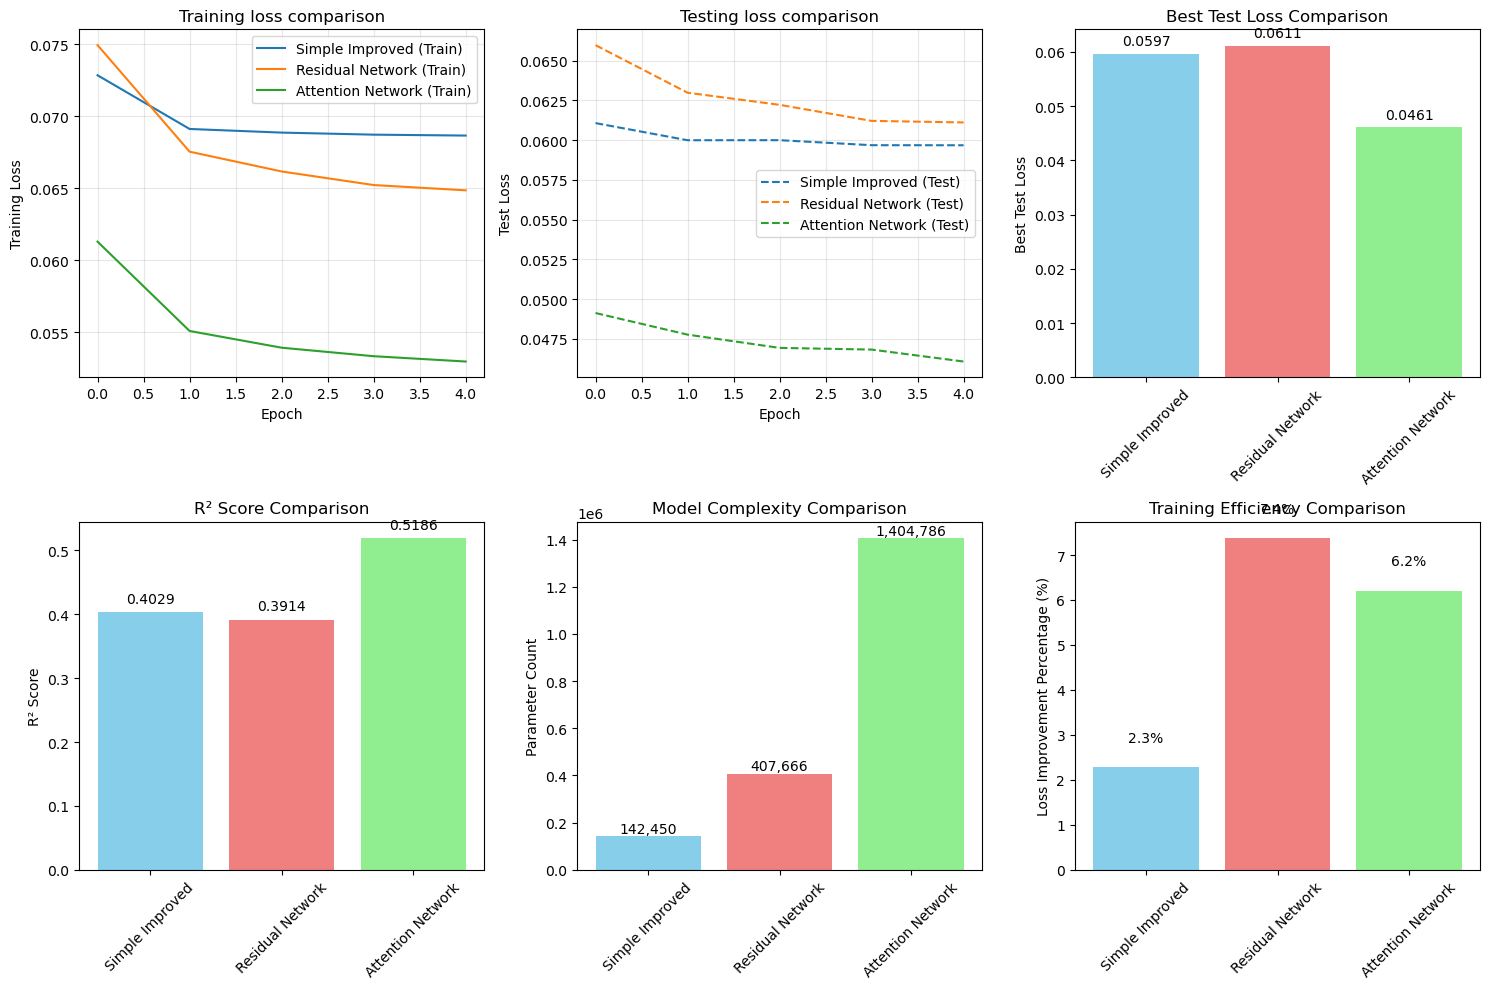

\n================================================================================
详细性能对比
模型名称                 最佳测试损失          R²分数       参数数量       损失改善      
--------------------------------------------------------------------------------
Simple Improved      0.059670        0.402912   142,450    2.3       %
Residual Network     0.061105        0.391381   407,666    7.4       %
Attention Network    0.046070        0.518551   1,404,786  6.2       %
\n推荐模型: Attention Network
理由: 在测试集上获得了最低的损失值 (0.046070)
模型性能仍有改进空间


In [15]:
# 结果比较和可视化
plt.figure(figsize=(15, 10))

# 1. 损失曲线对比
plt.subplot(2, 3, 1)
for name, result in results.items():
    plt.plot(result['train_losses'], label=f'{name} (Train)', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training loss comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
for name, result in results.items():
    plt.plot(result['test_losses'], label=f'{name} (Test)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Testing loss comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 最终性能对比
plt.subplot(2, 3, 3)
names = list(results.keys())
final_losses = [results[name]['best_test_loss'] for name in names]
colors = ['skyblue', 'lightcoral', 'lightgreen']
bars = plt.bar(names, final_losses, color=colors)
plt.ylabel('Best Test Loss')
plt.title('Best Test Loss Comparison')
plt.xticks(rotation=45)
# 添加数值标签
for bar, loss in zip(bars, final_losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{loss:.4f}', ha='center', va='bottom')

# 3. R²分数对比
plt.subplot(2, 3, 4)
r2_scores = [results[name]['r2_score'] for name in names]
bars = plt.bar(names, r2_scores, color=colors)
plt.ylabel('R² Score')
plt.title('R² Score Comparison')
plt.xticks(rotation=45)
# 添加数值标签
for bar, r2 in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{r2:.4f}', ha='center', va='bottom')

# 4. 参数数量对比
plt.subplot(2, 3, 5)
param_counts = [results[name]['num_params'] for name in names]
bars = plt.bar(names, param_counts, color=colors)
plt.ylabel('Parameter Count')
plt.title('Model Complexity Comparison')
plt.xticks(rotation=45)
# Add value labels
for bar, params in zip(bars, param_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'{params:,}', ha='center', va='bottom')

# 5. 训练效率对比 (损失下降幅度)
plt.subplot(2, 3, 6)
improvements = []
for name in names:
    result = results[name]
    if len(result['test_losses']) > 1:
        initial_loss = result['test_losses'][0]
        final_loss = result['best_test_loss']
        improvement = (initial_loss - final_loss) / initial_loss * 100
        improvements.append(improvement)
    else:
        improvements.append(0)

bars = plt.bar(names, improvements, color=colors)
plt.ylabel('Loss Improvement Percentage (%)')
plt.title('Training Efficiency Comparison')
plt.xticks(rotation=45)
# Add value labels
for bar, imp in zip(bars, improvements):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{imp:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 打印详细对比结果
print("\\n" + "="*80)
print("详细性能对比")
print("="*80)
print(f"{'模型名称':<20} {'最佳测试损失':<15} {'R²分数':<10} {'参数数量':<10} {'损失改善':<10}")
print("-"*80)

for name in names:
    result = results[name]
    if len(result['test_losses']) > 1:
        improvement = (result['test_losses'][0] - result['best_test_loss']) / result['test_losses'][0] * 100
    else:
        improvement = 0
    
    print(f"{name:<20} {result['best_test_loss']:<15.6f} {result['r2_score']:<10.6f} "
          f"{result['num_params']:<10,} {improvement:<10.1f}%")

# 推荐最佳模型
best_model_name = min(results.keys(), key=lambda x: results[x]['best_test_loss'])
print(f"\\n推荐模型: {best_model_name}")
print(f"理由: 在测试集上获得了最低的损失值 ({results[best_model_name]['best_test_loss']:.6f})")

if results[best_model_name]['r2_score'] > 0.8:
    print("该模型表现优秀，R²分数 > 0.8")
elif results[best_model_name]['r2_score'] > 0.6:
    print("该模型表现良好，R²分数 > 0.6")
else:
    print("模型性能仍有改进空间")